# Car Accident Severity  
*This is report for Capstone Project for Coursera Applied Data Science Capstone Course*

## Table of contents
* [Introduction](##introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>
In this report, we want to study the factors that related to severity in collisions and predict the severity level based on the various factors. With this information, we hope to prevent or mitigate injuries resulting from car accidents in future

## Data <a name="data"></a>
The data used in this study is accidents data for Seattle City. It includes all collisions data provided by SPD and recorded by Traffic Records from 2004 to present, in weekly frequency. Data is in structural format. 
Target variable is `SEVERITYCODE`, where a numeric code is used to indicate whether it is fatality, serious injury, injury, prop damage, or unknown. 
Features used include the following:
- `ADDRTYPE`: collision address type, whether it is Alley, Block, or Intersection
- `INCDATE`: the date of the incident
- `INCDTTM`: the date and time of the incident
- `UNDERINFL`: whether or not a driver involved was under the influence of drugs or alcohol
- `WEATHER`: a description of the weather conditions during the time of the collision
- `ROADCOND`: the condition of the road during the collision
- `LIGHTCOND`: the light conditions during the collision
- `SPEEDING`: whether or not speeding was a factor in the collision

### Acquiring Data
To acquire the data, we downloaded the data to local from the [link](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv) provided in the instruction

### Preprosessing and Feature Selection
Let's take a look at this data.

In [1]:
# let's first load all required libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
raw_df = pd.read_csv('Data-Collisions.csv')
raw_df.head()

C:\Users\lswma\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


We are only interested in few columns from the original dataframe. Let's extract them out.

In [3]:
columns = ['SEVERITYCODE', 'ADDRTYPE', 'INCDATE', 'INCDTTM',  'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING']
raw_df = raw_df[columns]
raw_df.head()

,SEVERITYCODE,ADDRTYPE,INCDATE,INCDTTM,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,2,Intersection,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,N,Overcast,Wet,Daylight,NaN
1,1,Block,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,0,Raining,Wet,Dark - Street Lights On,NaN
2,1,Block,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,0,Overcast,Dry,Daylight,NaN
3,1,Block,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,N,Clear,Dry,Daylight,NaN
4,2,Intersection,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,0,Raining,Wet,Daylight,NaN


In [4]:
raw_df.shape

(194673, 9)

Let’s see how many of each class is in our data set.

In [5]:
raw_df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

Out of total 194673 records, 136485 records with severity code of 1 (prop damage), and 58188 with severity code of 2 (injury). 
Let's take a closer look of each of the columns now. To fit the problem into a classification problem, let's replace the values, so that 1 indicates injury in the accident and 0 indicates no injury in the accident. 

In [6]:
raw_df['SEVERITYCODE'].replace(to_replace=[1,2], value=[0,1],inplace=True)
raw_df['SEVERITYCODE'].value_counts()

0    136485
1     58188
Name: SEVERITYCODE, dtype: int64

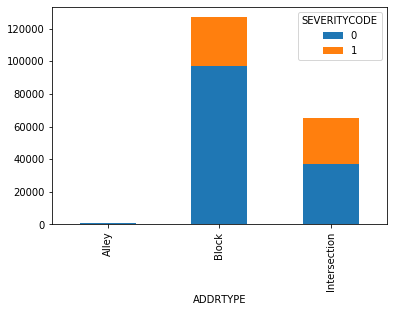

In [7]:
addrtype_valuecounts = raw_df.groupby(['ADDRTYPE'])['SEVERITYCODE'].value_counts().to_frame('counts')
addrtype_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

Most of the collisions occur at Block or Intersection. Compared to collisions at  Block, collisions at Intersection are more likely to be injuries.

In [8]:
raw_df['INCDATE'] = pd.to_datetime(raw_df['INCDATE'])
raw_df['INCDTTM'] = pd.to_datetime(raw_df['INCDTTM'])
raw_df.head()

,SEVERITYCODE,ADDRTYPE,INCDATE,INCDTTM,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,1,Intersection,2013-03-27 00:00:00+00:00,2013-03-27 14:54:00,N,Overcast,Wet,Daylight,NaN
1,0,Block,2006-12-20 00:00:00+00:00,2006-12-20 18:55:00,0,Raining,Wet,Dark - Street Lights On,NaN
2,0,Block,2004-11-18 00:00:00+00:00,2004-11-18 10:20:00,0,Overcast,Dry,Daylight,NaN
3,0,Block,2013-03-29 00:00:00+00:00,2013-03-29 09:26:00,N,Clear,Dry,Daylight,NaN
4,1,Intersection,2004-01-28 00:00:00+00:00,2004-01-28 08:04:00,0,Raining,Wet,Daylight,NaN


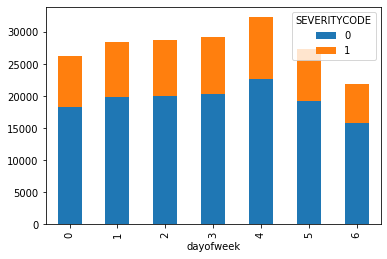

In [9]:
raw_df['dayofweek'] = raw_df['INCDATE'].dt.dayofweek
week_valuecounts = raw_df.groupby(['dayofweek'])['SEVERITYCODE'].value_counts().to_frame('counts')
week_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

There seems no significant difference in terms of number of accidents based on day of the week. Let's also check the propportion of injury cases against whether it is weekend or weekdays. 

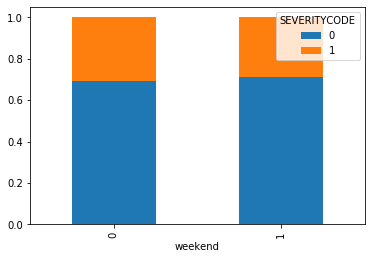

In [10]:
raw_df['weekend'] = raw_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
weekend_valuecounts = raw_df.groupby(['weekend'])['SEVERITYCODE'].value_counts(normalize=True).to_frame('counts')
weekend_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

No significant difference in the proportion of severity observed. 

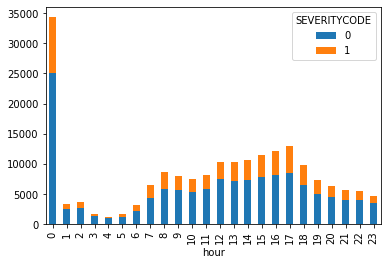

In [11]:
raw_df['hour'] = raw_df['INCDTTM'].dt.hour
hour_valuecounts = raw_df.groupby(['hour'])['SEVERITYCODE'].value_counts().to_frame('counts')
hour_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

Majority of the collisions recorded at midnight. Let's take a closer look at these records. It might also because some records are not recorded at specific timing and hence a default 00:00:00 is used as the incident time. Let's take a closer look to check if that's the case. 

C:\Users\lswma\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\lswma\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


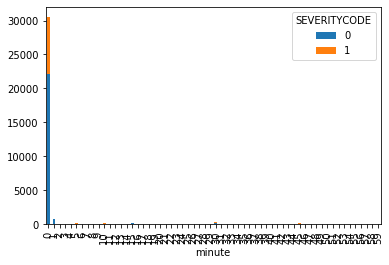

In [12]:
midnight_cases = raw_df.loc[raw_df.hour == 0]
midnight_cases['minute'] = midnight_cases['INCDTTM'].dt.minute
midnight_cases['second'] = midnight_cases['INCDTTM'].dt.second
midnight_minute_valuecounts = midnight_cases.groupby(['minute'])['SEVERITYCODE'].value_counts().to_frame('counts')
midnight_minute_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

In [13]:
default_time_cases = midnight_cases.loc[(midnight_cases.minute == 0) & (midnight_cases.second == 0)]
print(midnight_cases.shape[0])
print(default_time_cases.shape[0])

34381
30526


30526 of 34381 of the incidents that recorded at 0 hours are at 00:00:00 sharp, which is extremely unlikely to be the actual incident time, and more likely to be a default timestamp used due to lack of actual timing. Hence, we cannot use the time as part of the features. 

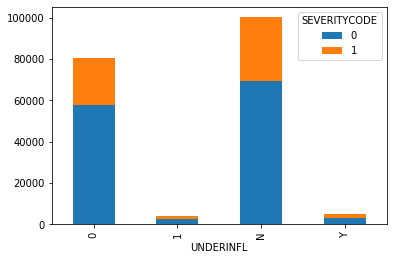

In [14]:
inf_valuecounts = raw_df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts().to_frame('counts')
inf_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

Let's replace `N` and `Y` and compare again. 

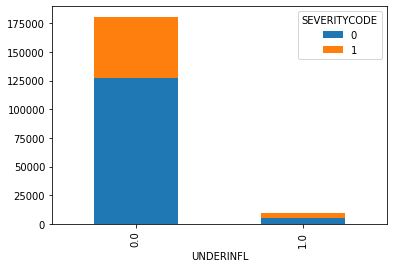

In [15]:
raw_df['UNDERINFL'].replace(to_replace=['N','Y'], value=[0,1],inplace=True)
raw_df['UNDERINFL'].replace(to_replace=['0','1'], value=[0,1],inplace=True)
inf_valuecounts = raw_df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts().to_frame('counts')
inf_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

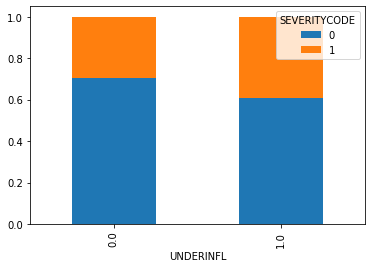

In [16]:
inf_valuecounts = raw_df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True).to_frame('counts')
inf_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

Based on the chart above, it suggests that when drivers are under influence of drugs or alchohol, the collisions are more likely to result in injuries. 

For this `UNDERINFL` column, there are also `NAN` recorded. Let's remove them from the data set. 

In [17]:
raw_df.dropna(subset = ["UNDERINFL"], inplace=True)
raw_df.shape

(189789, 12)

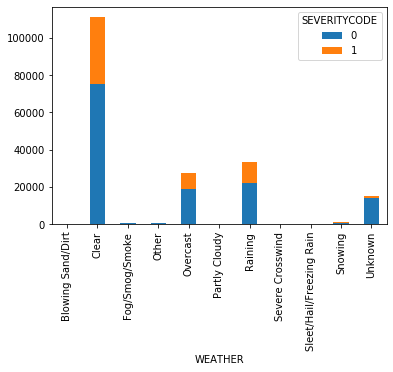

In [18]:
weather_valuecounts = raw_df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts().to_frame('counts')
weather_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

When it is partly cloudly, accidents are more likely to result in injuries. 

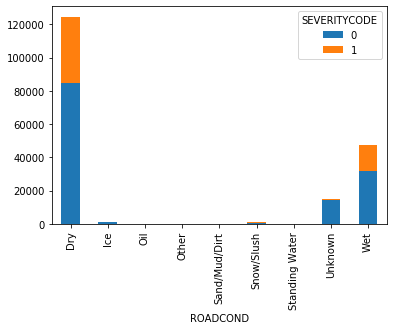

In [19]:
road_valuecounts = raw_df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts().to_frame('counts')
road_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

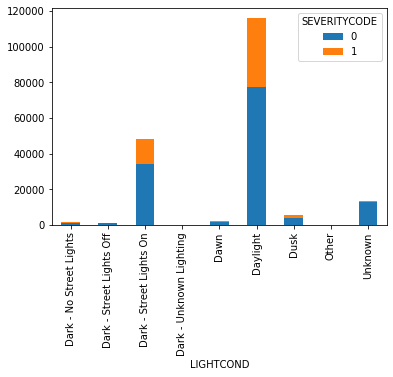

In [20]:
light_valuecounts = raw_df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts().to_frame('counts')
light_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

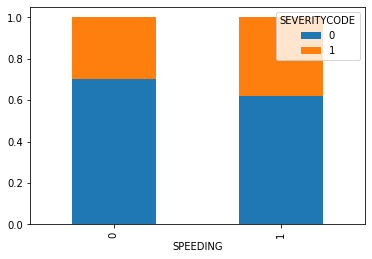

In [21]:
raw_df['SPEEDING'].replace(to_replace=[np.nan,'Y'], value=[0,1],inplace=True)
speed_valuecounts = raw_df.groupby(['SPEEDING'])['SEVERITYCODE'].value_counts(normalize=True).to_frame('counts')
speed_valuecounts.counts.unstack().plot(kind ='bar', stacked = True)

From the above bar plots, it also suggest that weather, road condition, light condition, speeding might also affect the likelihood of injury or not. Let's use them as features in this analysis. There are unknown weather, road condition, and light conditions in the data. Let's remove them first. 

In [22]:
raw_df = raw_df.loc[raw_df['WEATHER'] != 'Unknown']
raw_df = raw_df.loc[raw_df['ROADCOND'] != 'Unknown']
raw_df = raw_df.loc[raw_df['LIGHTCOND'] != 'Unknown']
raw_df.shape

(170887, 12)

Since `ADDRTYPE`, `WEATHER`, `ROADCOND`, `LIGHTCOND` are categorical variables, Let's apply one hot encoding to these categorical variables.

In [23]:
X = pd.concat([raw_df[['UNDERINFL', 'SPEEDING']], pd.get_dummies(raw_df['ADDRTYPE']), pd.get_dummies(raw_df['WEATHER']),
               pd.get_dummies(raw_df['ROADCOND']), pd.get_dummies(raw_df['LIGHTCOND'])], axis=1)
feature_columns = X.columns
X.head()

,UNDERINFL,SPEEDING,Alley,Block,Intersection,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Other,Overcast,...,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other
0,0.0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1,0.0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0.0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


Target variable in this case will be the `SEVERITYCODE` column. 

In [24]:
y = raw_df['SEVERITYCODE']

### Normalizing Data
Data Standardization give data zero mean and unit variance

In [25]:
X= preprocessing.StandardScaler().fit(X).transform(X)

## Methodology <a name="methodology"></a>
The problem is a classification problem as the target valuable is binary. A few models can be used for such classification problems, for example: 
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression  

However, as the goal of this study is also to understand the relative importance of each factor, and find ways to prevent or mitigate injuries resulting from collisions, a Decision Tree model is used in this case, so that we can also find the feature importance based on the study to guide us on ways to limit injuries from accidents. 

Before we train the model, let's split the train and test data set first. 

In [26]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (119620, 31) (119620,)
Test set: (51267, 31) (51267,)


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
tree.fit(X_train, y_train)
yhat=tree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat))

DecisionTrees's Accuracy:  0.6731425673435153


## Results <a name="results"></a>

In [28]:
from sklearn.metrics import jaccard_similarity_score, f1_score
test_yhat = tree.predict(X_test)
print("Jaccard Score of the Model is: ", jaccard_similarity_score(y_test, test_yhat))

Jaccard Score of the Model is:  0.6731425673435153


C:\Users\lswma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [29]:
print("F1 Score of the Model is :", f1_score(y_test, test_yhat))

F1 Score of the Model is : 0.008520205904976036


In [30]:
feature_importance = pd.DataFrame(tree.feature_importances_, index = feature_columns)
feature_importance.columns = ['importance']

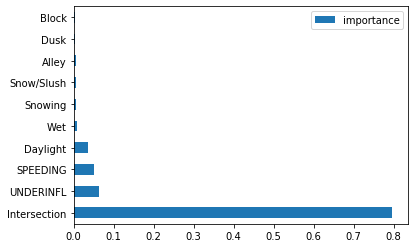

In [31]:
feature_importance.sort_values(['importance'], ascending=False, inplace=True)
feature_importance.head(10).plot(kind='barh')

From the above feature importance, we can conclude that address type is the most import feature when it comes to the likelihood of injury occurred during accidents. When a collision is at an intersection, such collisions are more likely to result in injuries. When a driver is under influence of drug or alchohol, or when a driver is speeding, a collision is also more likely to result in injuries.

## Conclusion <a name="conclusion"></a>

With the result of this study, we can help reduce the likelihood of injuries in accidents by placing more safety measures at intersections, or introducing more measures to identify drunk or speeding drivers. 
For future studies, we can also include a more detailed analysis of other factors, by collecting more comprehensive data, for example, if safety belt is used, or by recording the time of the accident more accurately. 